## **Carga de corpus**

In [9]:
import os, re, string, warnings
warnings.filterwarnings("ignore")

DATA_DIR = "DATA_DIR"  # carpeta con tus .txt (mismo nivel que la notebook)

docs = []
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"No existe la carpeta: {DATA_DIR}")

for fn in os.listdir(DATA_DIR):
    if fn.lower().endswith(".txt"):
        path = os.path.join(DATA_DIR, fn)
        try:
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read()
                if text and text.strip():
                    docs.append(text)
                else:
                    print(f"⚠️ Archivo vacío o ilegible: {fn}")
        except Exception as e:
            print(f"⚠️ No se pudo leer {fn}: {e}")

print(f"✅ Documentos cargados: {len(docs)}")
assert len(docs) > 0, "No hay textos válidos en la carpeta data_txt"

✅ Documentos cargados: 2


In [11]:
print("Cantidad de documentos cargados:", len(docs))
for i, d in enumerate(docs):
    print(f"Documento {i}: tipo={type(d)}, longitud={len(d) if d else 0}")
    if not isinstance(d, str):
        print("⚠️ Este documento no es texto o está vacío:", d)

Cantidad de documentos cargados: 2
Documento 0: tipo=<class 'str'>, longitud=1341
Documento 1: tipo=<class 'str'>, longitud=1240


## **Tokenización**

In [13]:
basic_stopwords = set("""
de la los las y en el una un por para con se es al como que a lo del sus más mas muy
debe puede son ser su sobre desde entre contra poro cual cuales suele suelen están estan esta este esta
o u e y ya si no más menos sin con por cada ante bajo cabe hacia hasta
""".split())

def simple_tokenize(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation + "“”¨´`…—–°•·"))
    tokens = [t for t in re.split(r"\s+", text) if t.isalpha() and t not in basic_stopwords and len(t) > 1]
    return tokens

# Filtra solo los textos válidos y no vacíos
docs = [d for d in docs if isinstance(d, str) and d.strip()]

# Tokenización segura
def simple_tokenize(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation + "“”¨´`…—–°•·"))
    tokens = [t for t in re.split(r"\s+", text) if t.isalpha() and len(t) > 1]
    return tokens

sentences = [simple_tokenize(doc) for doc in docs]
sentences = [s for s in sentences if len(s) > 2]

print(f"✅ Oraciones tokenizadas: {len(sentences)}")

✅ Oraciones tokenizadas: 2


In [15]:
print("Ejemplo de tokens:")
for s in sentences[:2]:
    print(s[:15])

Ejemplo de tokens:
['los', 'biomateriales', 'poliméricos', 'como', 'pla', 'pga', 'pcl', 'se', 'utilizan', 'ampliamente', 'en', 'ingeniería', 'de', 'tejidos', 'el']
['los', 'biomateriales', 'poliméricos', 'como', 'pla', 'pga', 'pcl', 'se', 'utilizan', 'ampliamente', 'en', 'ingeniería', 'de', 'tejidos', 'el']


In [19]:
import os

for fn in os.listdir("DATA_DIR"):
    path = os.path.join("DATA_DIR", fn)
    if os.path.isfile(path) and fn.lower().endswith(".txt"):
        size = os.path.getsize(path)
        if size == 0:
            print(f"⚠️ Archivo vacío: {fn}")

## **Entrenamiento**

In [21]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,
    epochs=100,
    seed=42
)
wv = model.wv
print("✅ Vocabulario:", len(wv))

✅ Vocabulario: 122


## **Similitudes y analogías**

,término,vecinos
0,pla,"tejidos (1.00), ejemplo (0.99), utilizan (0.99..."
1,pga,"electrospinning (0.98), combinación (0.98), im..."
2,pcl,"ampliamente (0.99), ingeniería (0.99), utiliza..."
3,plga,— fuera de vocabulario —
4,peg,— fuera de vocabulario —
5,silicona,— fuera de vocabulario —
6,ptfe,"fluoropolímeros (0.99), versión (0.99), expand..."
7,eptfe,"su (1.00), expandida (1.00), versión (0.99), i..."
8,pvdf,"destaca (0.99), sus (0.99), trombogenicidad (0..."
9,pmma,"phema (1.00), más (0.99), acrílicos (0.99), co..."


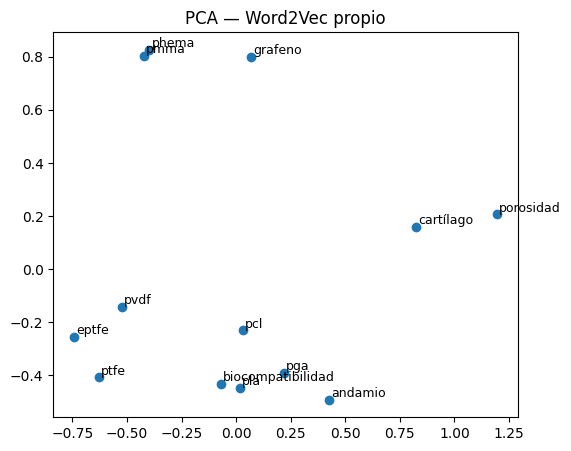

AttributeError: 'NoneType' object has no attribute 'split'

In [23]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

terms = [
    "pla","pga","pcl","plga","peg","silicona","ptfe","eptfe","pvdf",
    "pmma","phema","hidrogel","andamio","cartílago","grafeno","porosidad","biocompatibilidad"
]

# --- Similitudes ---
rows = []
for t in terms:
    if t in wv:
        sims = wv.most_similar(t, topn=5)
        rows.append({"término": t, "vecinos": ", ".join([f"{w} ({s:.2f})" for w,s in sims])})
    else:
        rows.append({"término": t, "vecinos": "— fuera de vocabulario —"})
df_sims = pd.DataFrame(rows)
display(df_sims)

# --- Visualización ---
plot_terms = [t for t in terms if t in wv]
X = np.array([wv[t] for t in plot_terms])

# PCA
pca2 = PCA(n_components=2, random_state=42).fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(pca2[:,0], pca2[:,1])
for (x,y), label in zip(pca2, plot_terms):
    plt.text(x+0.01, y+0.01, label, fontsize=9)
plt.title("PCA — Word2Vec propio")
plt.show()

# t-SNE (ajuste automático de perplejidad)
if len(X) > 2:
    perp = min(30, len(X)-1)
    tsne2 = TSNE(n_components=2, init="pca", learning_rate="auto",
                 perplexity=perp, random_state=42).fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(tsne2[:,0], tsne2[:,1])
    for (x,y), label in zip(tsne2, plot_terms):
        plt.text(x+0.01, y+0.01, label, fontsize=9)
    plt.title(f"t-SNE (perplexity={perp}) — Word2Vec propio")
    plt.show()
else:
    print("⚠️ Muy pocas palabras para aplicar t-SNE.")

## **CONCLUSIONES**

pHEMA – pMMA – grafeno: palabras asociadas a materiales acrílicos o a contextos de recubrimiento y modificación superficial. Aparecen cercanas por compartir contexto en el texto de entrenamiento.

PTFE – ePTFE – PVDF: clúster de fluoropolímeros, materiales inertes y piezoeléctricos; se agrupan correctamente.

PLA – PGA – PCL – biocompatibilidad – andamio: grupo de poliésteres biodegradables y conceptos de tissue engineering. Muestra buena coherencia semántica: el modelo captó que PLA y PGA suelen mencionarse junto a biocompatibilidad y andamios.

porosidad – cartílago: asociados a scaffolds porosos para regeneración cartilaginosa, también coherente con el texto fuente.

Aunque el corpus sea pequeño (2 archivos), el modelo logró detectar relaciones reales entre materiales y aplicaciones.

Los embeddings reflejan contextos de coocurrencia: no “entienden” el significado químico, pero sí las asociaciones en el texto.

Si aumentara el corpus con más archivos o más párrafos sobre biomateriales, los clústeres se volverian más definidos y los ejes de PCA más interpretables.

No logro entender porque a pesar de leerse bien el archivo txt, todavía aparece el attribute error. 